# Example 2: An Ideal, Ternary Mixture

#### This example shows the distillation column for a mixture of Benzene (heavy key), Toluene (intermediate) and Xylene (light key).

#### The graphs are different than in the ternary case.  The Rectifying and Stripping Sections are no longer linear.  The markings represent the equilibrium compositions.  
##### These sections follow a curved shape, starting closest to the pure light key component (unstable node), then traveling towards before curving away from the intermediate component (saddle node) before terminating closest to the heavy key (stable node).

##### Feasible columns exist when the Rectifying and Stripping Sections overlap, which is dependent on the Distillate and Bottoms Compositions, as well as the Reflux Ratio.

In [1]:
## IMPORT NECESSARY LIBRARIES ##
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
from scipy.optimize import fsolve
import ipywidgets as widgets
from IPython.display import display
from thermo_models.RaoultsLawModel import *
from distillation.DistillationModel import DistillationModel
from utils.AntoineEquation import * 
from IPython.display import clear_output
from tqdm import tqdm
from distillation.DistillationTernary import *
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interactive, Button, VBox, HBox, Output
from IPython.display import clear_output
import pickle
from utils.dictionary_approx import *
from distillation.residue_curves import *

with open("./utils/pickles/ex2_fixedpoints_dict.pkl", "rb") as f:
    rtofixedpoints_dict = pickle.load(f)

In [2]:
# Antoine Parameters for benzene
Ben_A = 4.72583
Ben_B = 1660.652
Ben_C = -1.461

# Antoine Parameters for toluene
Tol_A = 4.07827
Tol_B = 1343.943
Tol_C = -53.773

# Antoine Parameters for Xylene
Xyl_A = 4.14553
Xyl_B = 1474.403
Xyl_C = -55.377

P_sys = 1.0325
# Create Antoine equations for benzene and toluene
benzene_antoine = AntoineEquationBase10(Ben_A, Ben_B, Ben_C)
toluene_antoine = AntoineEquationBase10(Tol_A, Tol_B, Tol_C)
xylene_antoine = AntoineEquationBase10(Xyl_A, Xyl_B, Xyl_C)

# Create a Raoult's law object
TolBenXylSys = RaoultsLawModel(3,P_sys,[benzene_antoine, toluene_antoine, xylene_antoine])
# TolBenXylSys.plot_ternary_txy(100, keep_zero=0)

In [3]:

# Create widgets
option = widgets.Dropdown(
    options=['Feed-Distillate', 'Feed-Bottoms'],
    description='Define:',
    disabled=False
)

z1_1 = widgets.FloatText(value=0.3, description='zF1:')
z1_2 = widgets.FloatText(value=0.3, description='zF2:')

z2_1 = widgets.FloatText(value=0.6, description='zD1:')
z2_2 = widgets.FloatText(value=0.2, description='zD2:')

submit_button = widgets.Button(description='Submit')

# Update text fields when choice changes
def on_option_change(change):
    new_option = change['new']
    z1_1.description, z1_2.description = f'z{new_option.split("-")[0][0]}1:', f'z{new_option.split("-")[0][0]}2:'
    z2_1.description, z2_2.description = f'z{new_option.split("-")[1][0]}1:', f'z{new_option.split("-")[1][0]}2:'

option.observe(on_option_change, names='value')

# Function to run when 'Submit' is clicked
def plot_mass_balance(btn):
    z_1_1, z_1_2 = z1_1.value, z1_2.value
    z_1_3 = 1 - z_1_1 - z_1_2
    z_2_1, z_2_2 = z2_1.value, z2_2.value
    z_2_3 = 1 - z_2_1 - z_2_2

    if z_1_3 < 0 or z_2_3 < 0:
        print("Invalid fractions; sum must be <= 1")
        return
    
    fig, ax = plt.subplots()
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.plot([0, 1], [1, 0], 'k--')
    ax.set_aspect('equal')

    label1, label2 = option.value.split("-")
    alpha = (z_2_2 - z_1_2)/(z_2_1 - z_1_1)
    beta = - z_1_1 * alpha + z_1_2
    x = np.linspace(0, 1, 100)
    y = alpha * x + beta

    
    if option.value == 'Feed-Distillate':
        ax.plot([z_1_1, z_2_1], [z_1_2, z_2_2], 'ro-', label=f'{label1}-{label2}')
        for index,i in enumerate(x):
            if i > z_1_1:
                x = x[:index]
                y = y[:index]
                break
            
        ax.plot(x, y, 'r--', label = f'Bottoms Composition Space')
    else:  # Feed-Bottoms
        ax.plot([z_1_1, z_2_1], [z_1_2, z_2_2], 'bo-', label=f'{label1}-{label2}')
        for index,i in enumerate(x):
            if i > z_1_1:
                x = x[:index]
                y = y[:index]
                break
        ax.plot(x, y, 'r--', label = f'Distillate Composition Space')

    ax.text(z_1_1, z_1_2, label1, fontsize=12, ha='right')
    ax.text(z_2_1, z_2_2, label2, fontsize=12, ha='right')
    
    ax.legend()
    plt.show()

# Connect the button click to the function
submit_button.on_click(plot_mass_balance)

# Display widgets
display(option, z1_1, z1_2, z2_1, z2_2, submit_button)


Dropdown(description='Define:', options=('Feed-Distillate', 'Feed-Bottoms'), value='Feed-Distillate')

FloatText(value=0.3, description='zF1:')

FloatText(value=0.3, description='zF2:')

FloatText(value=0.6, description='zD1:')

FloatText(value=0.2, description='zD2:')

Button(description='Submit', style=ButtonStyle())

In [4]:
R1_slider =  widgets.FloatLogSlider(value=1.0, base=10, min=0, max=2, step=0.001,  description='Reflux Ratio:', readout_format='.1f')
go_button = widgets.Button(description='Create Model', width='15%', margin='0 10px 0 0')
out_oplines = Output()

def plot_rect_strip_ex2(R = R1_slider):
    plt.close('all')  # Ensure that any existing figures are closed before plotting a new one.
    xF = np.array([0.3, 0.3, 0.4])
    xD = np.array([0.990, 0.0100, 1e-10])
    xB = np.array([1e-5, 0.4261,0.5749])
    distillation_model = DistillationModelTernary(TolBenXylSys, xF = xF, xD = xD, xB = xB, reflux = R)
    fixed_points = approximate_value(rtofixedpoints_dict,R)
    fig, ax = plt.subplots(1,1,figsize= (5,5))
    distillation_model.plot_rect_strip_comp(ax)
    
    for index,point in enumerate(fixed_points['values']):
        ax.scatter(point[0], point[1], marker='x', color='black', s=100, linewidths= 10)
        if fixed_points['source_indices'][index] == 0:
            label = "Unstable"
        elif fixed_points['source_indices'][index] == 1:
            label = "saddle"
        elif fixed_points['source_indices'][index] == 2:
            label = "stable"
        else:
            label = "unexpected node: error"
        ax.text(point[0], point[1], f' {label}', verticalalignment='bottom', horizontalalignment='right')
    plt.subplots_adjust(hspace=0)
    plt.show()

In [5]:
def on_go_button_click(b):
    with out_oplines:
        clear_output(wait=True)
        plt.close('all')  # Close all open matplotlib plots
        plot_rect_strip_ex2( R=R1_slider.value)
        
go_button = Button(description='Generate Plot')
go_button.on_click(on_go_button_click)

layout1 = VBox([HBox([R1_slider, go_button]), out_oplines])
display(layout1)

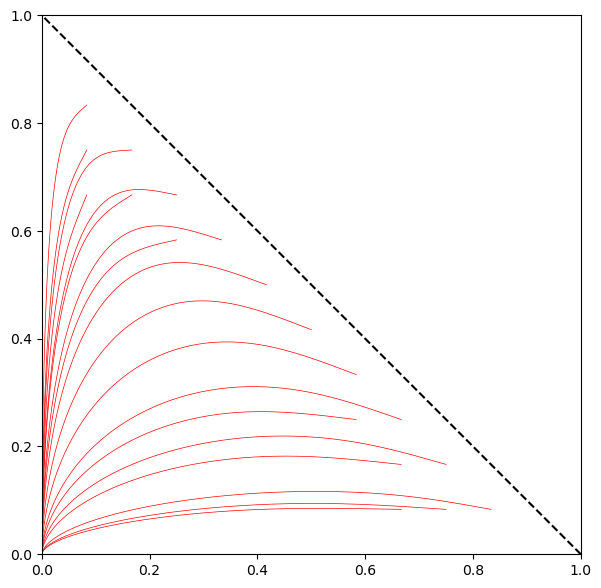

In [6]:
out_residue = Output()

rcm = residue_curve(TolBenXylSys)
fig, ax = plt.subplots(1,1,figsize= (7,7))
rcm.plot_residue_curve_mod(ax,13)

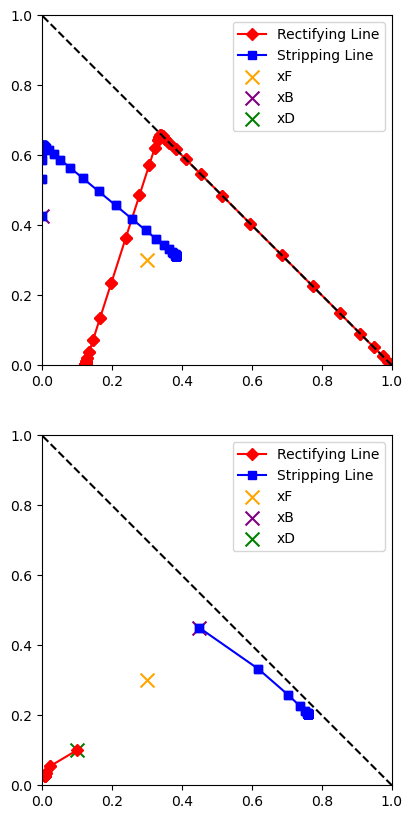

In [7]:
#Show different splits


fig, ax = plt.subplots(2,1,figsize= (5,10))

#Possible case
xF = np.array([0.3, 0.3, 0.4])
xD = np.array([0.990, 0.0100, 1e-10])
xB = np.array([1e-5, 0.4261,0.5749])
R = 2
distillation_model = DistillationModelTernary(TolBenXylSys, xF = xF, xD = xD, xB = xB, reflux = R)
distillation_model.plot_rect_strip_comp(ax[0])

#Impossible case
xF = np.array([0.3, 0.3, 0.4])
xD = np.array([0.1, 0.1, 0.8])
xB = np.array([0.45, 0.45,0.1])
R = 2
distillation_model = DistillationModelTernary(TolBenXylSys, xF = xF, xD = xD, xB = xB, reflux = R)
distillation_model.plot_rect_strip_comp(ax[1])

In [8]:
xD1_slider =  widgets.FloatSlider(value=0.96, min=0.00, max=1.00, step=0.001,  description='xD Benzene:', readout_format='.2f')
xD2_slider =  widgets.FloatSlider(value=0.03, min=0.00, max=0.04, step=0.001,  description='xD Toluene:', readout_format='.2f')
xF1_slider =  widgets.FloatSlider(value=0.40, min=0.00, max=1.00, step=0.001,  description='xF Benzene:', readout_format='.2f')
xF2_slider =  widgets.FloatSlider(value=0.40, min=0.00, max=0.60, step=0.001,  description='xF Toluene:', readout_format='.2f')
go_button = widgets.Button(description='Create Model', width='15%', margin='0 10px 0 0')
out_oplines = Output()

def update_range(change):
    xD2_slider.max = (1 - xD1_slider.value)
    xF2_slider.max = (1 - xF1_slider.value)

# Attach the function to the value change event of slider1
xD1_slider.observe(update_range, 'value')
xF1_slider.observe(update_range, 'value')


def plot_rect_strip_ex2(R = 2.5, VB = 1.5):
    xB1 = (xF1_slider.value - (VB * (xD1_slider.value - xF1_slider.value) / (R+1)))
    xB2 = (xF2_slider.value - ((xF1_slider.value - xB1) * (xF2_slider.value - xD2_slider.value) / (xF1_slider.value - xD1_slider.value)))
    plt.close('all')  # Ensure that any existing figures are closed before plotting a new one.
    xF = np.array([xF1_slider.value, xF2_slider.value, (1 - xF1_slider.value - xF2_slider.value)])
    xD = np.array([xD1_slider.value, xD2_slider.value, (1 - xD1_slider.value - xD2_slider.value)])
    xB = np.array([xB1, xB2, (1 - xB1 - xB2)])
    distillation_model = DistillationModelTernary(TolBenXylSys, xF = xF, xD = xD, xB = xB, reflux = R)
    fig, ax = plt.subplots(1,1,figsize= (5,5))
    distillation_model.plot_rect_strip_comp(ax)
    plt.subplots_adjust(hspace=0)
    plt.show()


In [9]:
def on_go_button_click(b):
    with out_oplines:
        clear_output(wait=True)
        plt.close('all')  # Close all open matplotlib plots
        plot_rect_strip_ex2(R=1.5)
        
go_button = Button(description='Generate Plot')
go_button.on_click(on_go_button_click)

title_label = widgets.Label(value="Change composition values to see if the column is feasible. \n" 
"A feasible column will have intersecting Rectifying and Stripping Lines.", style={'font-weight': 'bold'})

layout = VBox([
    title_label,
    HBox([xD1_slider, xD2_slider]),
    HBox([xF1_slider, xF2_slider, go_button]),
    out_oplines
    ])
display(layout)